In [1]:
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:955: UserWarning: Illegal line #1
	"TkAgg
"
	in file "/Users/macbook/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)


In [2]:
MIN_DELAY = 1
MAX_DELAY = 7
MAX_SYNAPSES = 5
INPUT_SIZE = 20
OUTPUT_SIZE = 2
REPEAT = 5
T = 100

In [3]:
class SRM:
    def __init__(self, input_size, hidden_size, output_size=2, threshold=1, tau=1, t_s=1):
        """
        :param input_size: Number of neurons on input layer
        :param hidden_size: Number of neurons on hidden layer
        :param output_size: Number of neurons on output layer
        :param threshold: Spiking threshold
        :param tau: Membrane-time-constant (t_m)
        :param t_s: Current-time-constant 
        :return: ``None``
        """
        
        self.threshold = threshold
        self.tau = tau
        self.t_s = t_s
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = 2
        
        # Weights and delays
        self.w1 = np.random.rand(input_size, hidden_size)
        self.w2 = np.random.rand(hidden_size, output_size)
        self.d1 = np.random.randint(MIN_DELAY, MAX_DELAY + 1, size=(input_size, hidden_size))
        self.d2 = np.random.randint(MIN_DELAY, MAX_DELAY + 1, size=(hidden_size, output_size))    
        
    def eta(self, s):
        return -self.threshold * np.exp(-s/self.tau) * np.heaviside(s, 0)
    
    def eps(self, s, d):
        # d -- axonal transmission delay
        return (s - d)/self.t_s*np.exp(-(s - d)/self.t_s) * np.heaviside(s - d, 0)
    
    def u(self, t, last_t, d, w, p_last_t):
        return self.eta(t - last_t) + np.sum(w * self.eps(np.transpose(t - p_last_t - np.transpose(d)), d), axis=0)
    
    def update_spike(self, u, t):
        return (u[t] > self.threshold).astype(int)
    
    def update_last(self, last, spikes, t):
        return np.maximum(last, spikes[t]*t)
    
    def run(self, u_in, time):
        self.u_hidden = np.zeros((time, self.hidden_size))
        self.u_out = np.zeros((time, self.output_size))
        
        self.last_in = np.zeros((u_in.shape[0]))
        self.last_hidden = np.zeros((self.hidden_size))
        self.last_out = np.zeros((self.output_size))
        
        self.spikes_hidden = np.zeros((time, self.hidden_size))
        self.spikes_out = np.zeros((time, self.output_size))
        
        for t in range(time):
            self.u_hidden[t] = self.u(t, self.last_hidden, self.d1, self.w1, self.last_in)
            self.u_out[t] = self.u(t, self.last_out, self.d2, self.w2, self.last_hidden)
            
            self.spikes_hidden[t] = self.update_spike(self.u_hidden, t)
            self.spikes_out[t] = self.update_spike(self.u_out, t)
            
            self.last_in = self.update_last(self.last_in, u_in.T, t)
            self.last_hidden = self.update_last(self.last_hidden, self.spikes_hidden, t)
            self.last_out = self.update_last(self.last_out, self.spikes_out, t)
        return self.u_out

In [4]:
def time_to_next_spike(k):
    return int(-np.log(1. - np.random.rand()) / k) + 1

In [5]:
def generate_spikes(k=0.9):
    spikes = np.zeros((10*T,))
    t = 0
    while (t < T):
        t += time_to_next_spike(k)
        spikes[t] = 1
    return spikes[:T]

In [6]:
def generate_input():
    spikes = np.array([generate_spikes() for _ in range(INPUT_SIZE)])
    return np.repeat(spikes, REPEAT, axis=1)

In [7]:
pattern1 = generate_input()
pattern2 = generate_input()

In [8]:
time = REPEAT * T

In [9]:
def plot_result(u, time, name=''):
    t = range(time)
    plt.figure(figsize=(15, 5))
    plt.plot(t, u[:, 0])
    plt.plot(t, u[:, 1])
    plt.xlabel('Time')
    plt.ylabel('Potential' + name)
    plt.show()

In [10]:
def noise_pattern(a, p):
    return np.where(np.random.uniform(size=a.shape) < p, 2, a)

In [11]:
noise_pattern(pattern2, 0.1).shape

(20, 500)

# Experiments

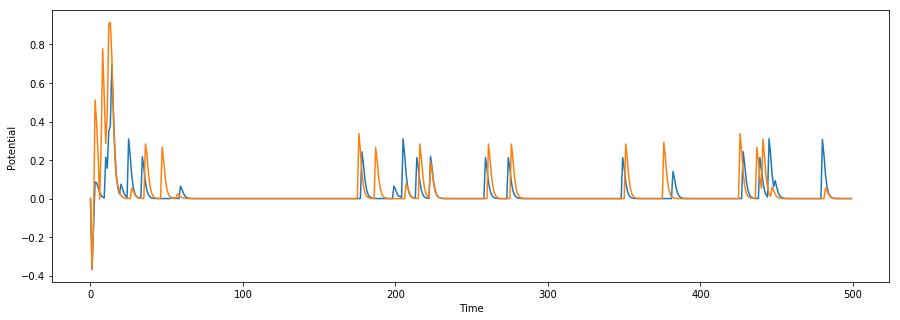

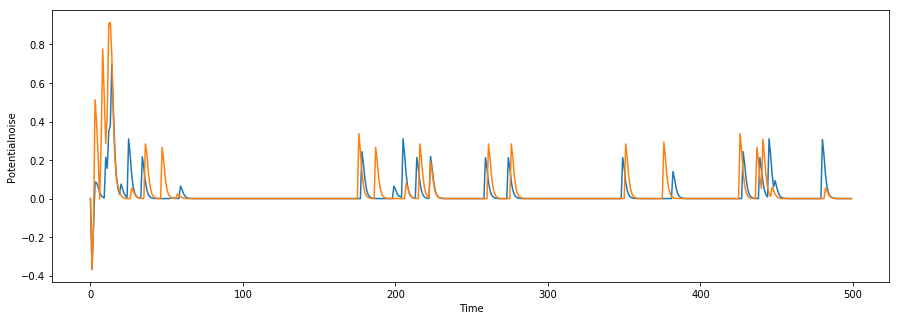

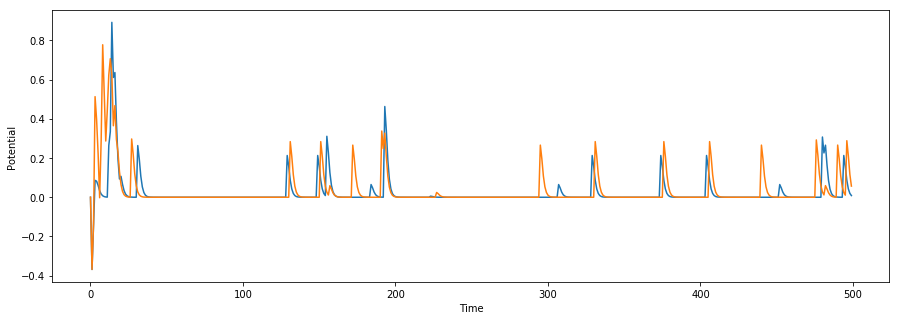

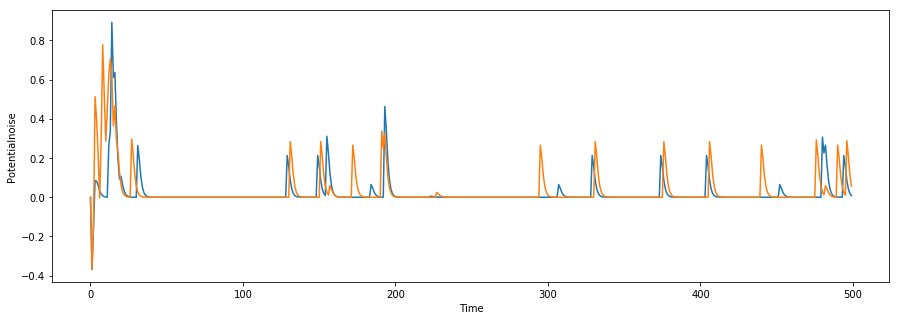

In [12]:
SNN = SRM(INPUT_SIZE, 10, OUTPUT_SIZE)
u_1 = SNN.run(pattern1, time)
u_1_noise = SNN.run(noise_pattern(pattern1, 0.5), time)
u_2 = SNN.run(pattern2, time)
u_2_noise = SNN.run(noise_pattern(pattern2, 0.5), time)
plot_result(u_1, time)
plot_result(u_1, time, 'noise')
plot_result(u_2, time)
plot_result(u_2, time, 'noise')

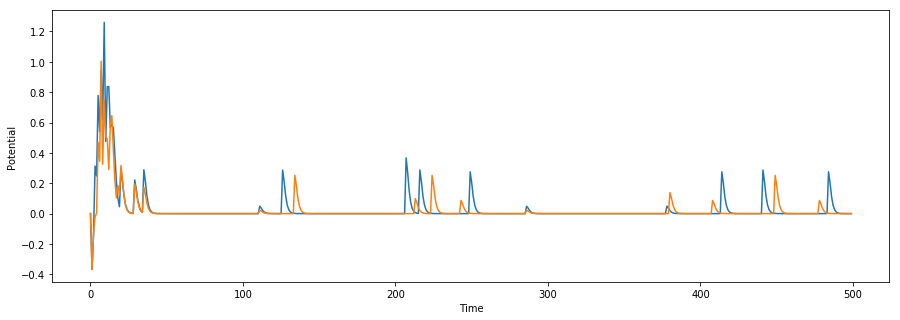

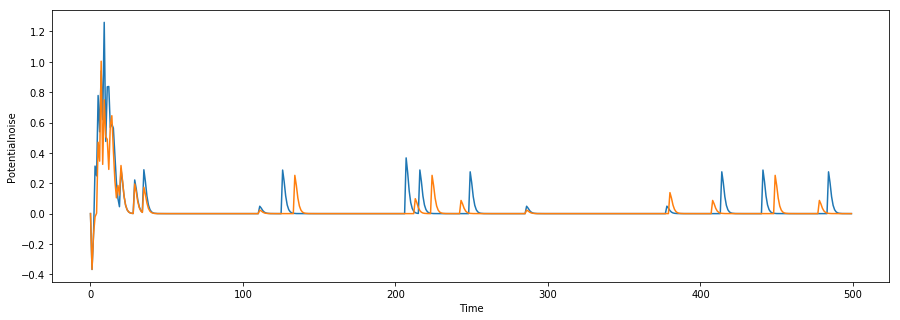

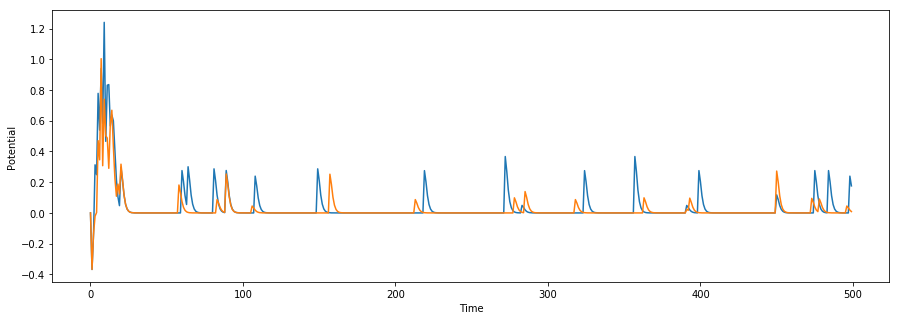

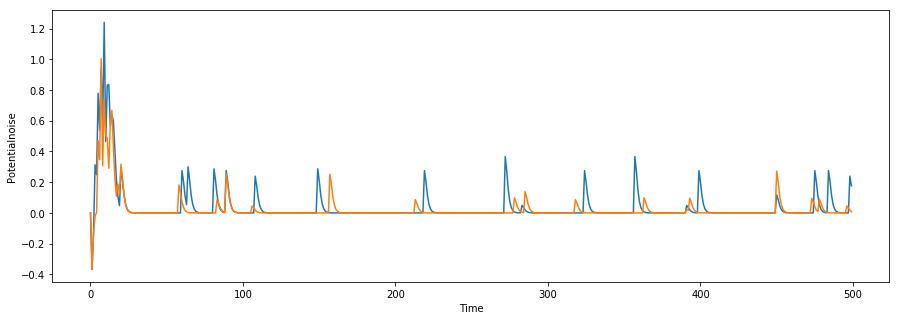

In [13]:
SNN = SRM(INPUT_SIZE, 20, OUTPUT_SIZE)
u_1 = SNN.run(pattern1, time)
u_1_noise = SNN.run(noise_pattern(pattern1, 0.1), time)
u_2 = SNN.run(pattern2, time)
u_2_noise = SNN.run(noise_pattern(pattern2, 0.1), time)
plot_result(u_1, time)
plot_result(u_1, time, 'noise')
plot_result(u_2, time)
plot_result(u_2, time, 'noise')

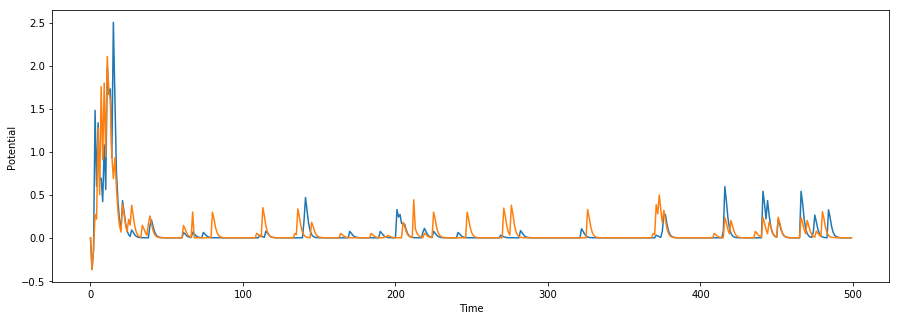

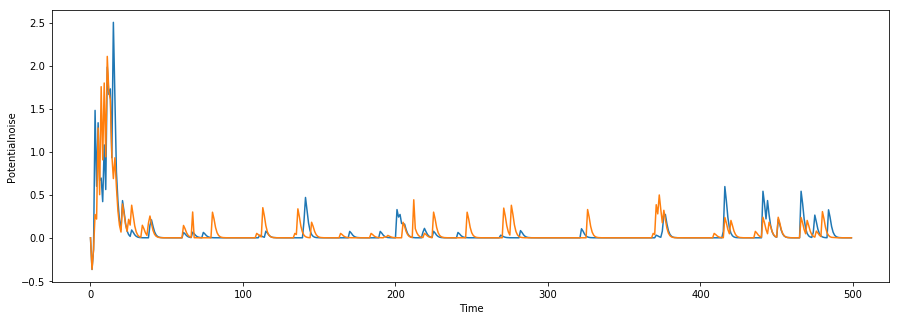

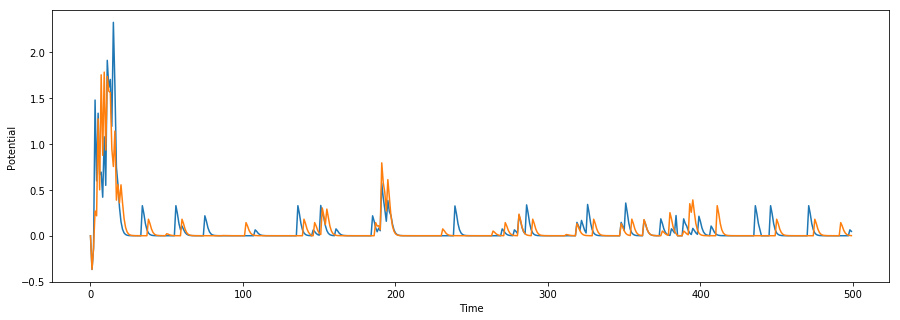

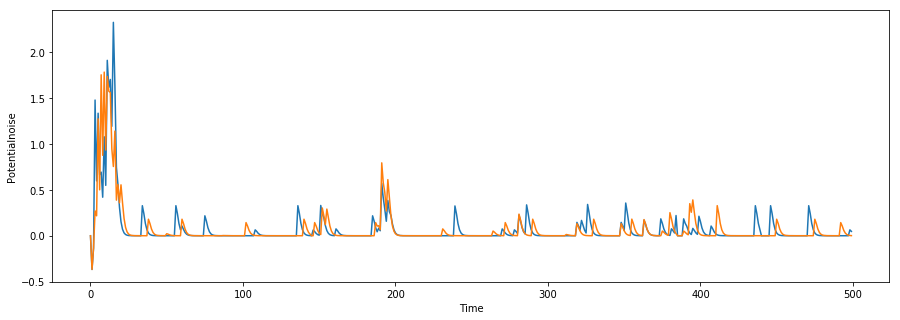

In [14]:
SNN = SRM(INPUT_SIZE, 50, OUTPUT_SIZE)
u_1 = SNN.run(pattern1, time)
u_1_noise = SNN.run(noise_pattern(pattern1, 0.05), time)
u_2 = SNN.run(pattern2, time)
u_2_noise = SNN.run(noise_pattern(pattern2, 0.05), time)
plot_result(u_1, time)
plot_result(u_1, time, 'noise')
plot_result(u_2, time)
plot_result(u_2, time, 'noise')

# Анализ

1. При наличие шума количество спайков увеличивается.
2. При увеличение шума паттерн перестает быть заметен.
3. Количество спайков намного больше в начале процесса.
4. Количество спайков пропорционально количеству нейронов на скрытом слое.